# Compare Performance between Parsl and Colmnea
We want to see if Colmena's strategy of overlapping simulation and machine learning had any noticable effect.
The primary way we can do that is to evaluate the time-to-solution for finding well-performing molecules.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

## Load in the Runs
We saved the performance data from the examples and will load them back into disk here.

Colmena saves results as a JSON object. We can load them in via Pandas

In [2]:
results = pd.read_json('run-data/batched-results.json', lines=True)

## Plot the Resource Utilization
We want to make sure that Colmena is using nodes effectively by plotting the overall utilization.

First step is to compute time a computation started, finished, and when it was received by the thinker.

In [3]:
start_time = results['time_compute_started'].min()
results['walltime_start'] = results['time_compute_started'] - start_time
results['walltime_finish'] = results['walltime_start'] + results['time_running']
results['walltime_received'] = results['time_result_received'] - start_time

We next assign unique names and id numbers to each worker given their hostname and worker ID

In [4]:
results['worker_name'] = results['worker_info'].apply(lambda x: f'{x["hostname"]}-{x["PARSL_WORKER_RANK"]}')
unique_workers = sorted(set(results['worker_name']))
results['worker_id'] = results['worker_name'].apply(unique_workers.index)
n_workers = len(unique_workers)
print(f'Found {n_workers} unique workers')

Found 4 unique workers


Finally, let's plot when the workers are being used and for which task

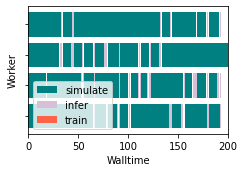

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Colors for each type of task
method_color = {
    'compute_vertical': 'teal',
    'train_model': 'tomato',
    'run_model': 'thistle'
}

# Labels for each type of task
method_label = {
    'compute_vertical': 'simulate',
    'train_model': 'train', 
    'run_model': 'infer'
}

# Plot each method separately
for method, group in results.groupby('method'):
    ax.barh(y=group["worker_id"],
            width=group["time_running"],
            left=group['walltime_start'], 
            color=method_color[method],
            label=method_label[method],
            edgecolor='none')
    
# Add in a legend
ax.legend()
    
# Make some labels
ax.set_yticks(range(n_workers))
ax.set_yticklabels([])
ax.set_ylabel('Worker')

ax.set_xlabel('Walltime')
ax.set_xlim([0, results['walltime_finish'].max()])

fig.tight_layout()

You can see Colmena does a good job at overlapping tasks of various types. Our next question is "does this actually matter?" 

## Measuring Scientific Performance
The key goal we have is to find the most number of "good" molecules in the shortest time.

Retrieve the molecule properties from the Colmena jobs

In [6]:
colmena_mols = results.query('method=="compute_vertical" and success').copy()
colmena_mols['smiles'] = colmena_mols['inputs'].apply(lambda x: x[0][0])
colmena_mols['ie'] = colmena_mols['value']

In [7]:
colmena_mols[['smiles', 'ie', 'walltime_finish']].head()

,smiles,ie,walltime_finish
0,COC1=NC(=O)OC=C1,0.532625,8.631001
1,CCC1(CC1)OC1CC1,0.478604,14.061893
2,CC1OC2CC2(C)C1=O,0.496962,14.617035
3,CC12OC1COCC=C2,0.500732,18.309748
4,CC1N2CC2C2OC12C,0.481646,25.855418


Load in the Parsl results

In [8]:
parsl_mols = pd.read_csv('run-data/parsl-results.csv')

In [9]:
parsl_mols.head()

,smiles,ie,batch,time
0,N#CC12CC=CC1N2,0.511661,0,9.717656
1,NC(=O)C12OC1C1NC21,0.510931,0,13.132708
2,OCCC1(CC#N)CO1,0.519072,0,13.629854
3,CCC12CC(=NO)C1N2,0.488868,0,13.964025
4,O=CC12OCC3C1NC23,0.495737,0,19.778827


Plot the the completion time and 

Text(0, 0.5, 'IE (Ha)')

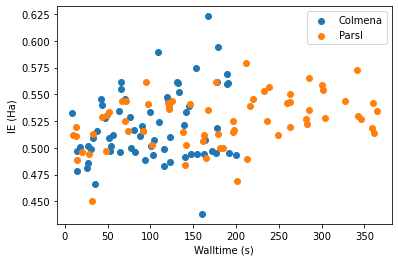

In [10]:
fig, ax = plt.subplots()

ax.scatter(colmena_mols['walltime_finish'], colmena_mols['ie'], label='Colmena')
ax.scatter(parsl_mols['time'], parsl_mols['ie'], label='Parsl')

ax.legend()

ax.set_xlabel('Walltime (s)')
ax.set_ylabel('IE (Ha)')

We can already see that the Parsl application takes much longer evaluate the same number of molecules. 

Even if it is slower, this does not mean Parsl is giving us worse results. Let's measure that by how many molecules we find with a very large IE (>0.55 Ha)

In [11]:
thr = 0.55
colmena_mols.sort_values('walltime_finish', ascending=True, inplace=True)
colmena_mols['best_found'] = (colmena_mols['ie'] > thr).cumsum()

In [12]:
parsl_mols.sort_values('time', ascending=True, inplace=True)
parsl_mols['best_found'] = (parsl_mols['ie'] > thr).cumsum()

Text(0, 0.5, 'Top Molecules Found')

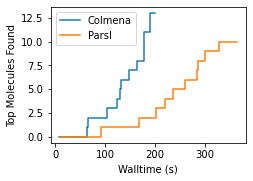

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.step(colmena_mols['walltime_finish'], colmena_mols['best_found'], label='Colmena')
ax.step(parsl_mols['time'], parsl_mols['best_found'], label='Parsl')

ax.legend()

ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Top Molecules Found')

We can see that Colmena takes much less time to find a more molecules, which is a result of the Colmena application being able to manage different kinds of tasks at the same time.

Text(0, 0.5, 'Top Molecules Found')

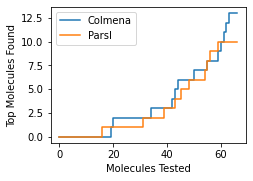

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.step(range(len(colmena_mols)), colmena_mols['best_found'], label='Colmena')
ax.step(range(len(parsl_mols)), parsl_mols['best_found'], label='Parsl')

ax.legend()

ax.set_xlabel('Molecules Tested')
ax.set_ylabel('Top Molecules Found')

You can even see that the machine learning performs just as well for the Parsl application. Both the Parsl and Colmena find similar numbers of top molecules at a given numbers of simulations performed. It is purely the access to intelligent scheduling policies via Colmena which enable the improved science-per-core-hour.